# 0. Configuration

In [1]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
INTERACTIONS_PATH = '/Users/s.khalilbekov/Downloads/data_kion/interactions_df.csv'
ITEMS_METADATA_PATH = 'https://drive.google.com/file/d/12a80lS3vXQOl6i6ENgz-WqWw3Wms0nqB/view?usp=share_link'
USERS_DATA_PATH = 'https://drive.google.com/file/d/1MwPaye0cRi53czLqCnH0bOuvIhOeNlAx/view?usp=share_link'

# 1. Modules and functions

In [77]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import shap
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. 1. Helper functions to avoid copy paste

In [3]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

# 2. Main

## 2.1. Load Data

`interactions` dataset shows list of movies that users watched, along with given `total_dur` in seconds and `watched_pct` proportion:

In [4]:
# interactions data
interactions = pd.read_csv(INTERACTIONS_PATH)
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.000
1,699317,1659,2021-05-29,8317,100.000
2,656683,7107,2021-05-09,10,0.000
3,864613,7638,2021-07-05,14483,100.000
4,964868,9506,2021-04-30,6725,100.000


`movies_metadata` dataset shows the list of movies existing on OKKO platform:

In [5]:
# information about films etc
movies_metadata = read_csv_from_gdrive(ITEMS_METADATA_PATH)
movies_metadata.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.000,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.000,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.000,"зарубежные, приключения, комедии",США,NaN,16.000,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.000,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.000,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [6]:
users_data = read_csv_from_gdrive(USERS_DATA_PATH)
users_data.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


## 2.2. Train/test split

## 2.3 Data preparation using LightFM Dataset (first-level model)

To use implicit kNN method `fit` we need a sparse matrix in COOrdinate format. To achieve that we will use `scipy.sparse.coo_matrix` from scipy;


In [7]:
# remove redundant data points
interactions_filtered = interactions.loc[interactions['total_dur'] > 300].reset_index(drop = True)

In [8]:
print(interactions.shape, interactions_filtered.shape)

(5476251, 5) (4195689, 5)


In [9]:
interactions_filtered['last_watch_dt'] = pd.to_datetime(interactions_filtered['last_watch_dt'])

In [10]:
# set dates params for filter
MAX_DATE = interactions_filtered['last_watch_dt'].max()
MIN_DATE = interactions_filtered['last_watch_dt'].min()
TEST_INTERVAL_DAYS = 14

print(f"min date in filtered interactions: {MAX_DATE}")
print(f"max date in filtered interactions:: {MIN_DATE}")

min date in filtered interactions: 2021-08-22 00:00:00
max date in filtered interactions:: 2021-03-13 00:00:00


In [11]:
TEST_MAX_DATE = MAX_DATE - dt.timedelta(days = TEST_INTERVAL_DAYS)

In [12]:
# define global train and test
global_train = interactions_filtered.loc[interactions_filtered['last_watch_dt'] < TEST_MAX_DATE]
global_test = interactions_filtered.loc[interactions_filtered['last_watch_dt'] >= TEST_MAX_DATE]

print(global_train.shape, global_test.shape)

(3530674, 5) (665015, 5)


In [13]:
# now, we define "local" train and test to use some part of the global train for ranker
local_train_thresh = global_train['last_watch_dt'].quantile(q = .7, interpolation = 'nearest')
print(local_train_thresh)

2021-07-11 00:00:00


In [14]:
global_train = global_train.dropna().reset_index(drop = True)

In [15]:
local_train = global_train.loc[global_train['last_watch_dt'] < local_train_thresh]
local_test = global_train.loc[global_train['last_watch_dt'] >= local_train_thresh]

print(local_train.shape, local_test.shape)

(2451040, 5) (1079183, 5)


In [16]:
# finally, we will focus on warm start -- remove cold start users
local_test = local_test.loc[local_test['user_id'].isin(local_train['user_id'].unique())]
print(local_test.shape)

(579382, 5)


In [17]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(local_train['user_id'].unique(), local_train['item_id'].unique())

In [18]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
# lightfm_mapping

In [19]:
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  539173
user features mapper length -  539173
movies mapper length -  13006
Users movie features mapper length -  13006


In [20]:
# here we create inverted mappers to check recommendations later
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [21]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [22]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(local_train[['user_id', 'item_id']]))

In [23]:
train_mat

<539173x13006 sparse matrix of type '<class 'numpy.int32'>'
	with 2451040 stored elements in COOrdinate format>

In [24]:
train_mat_weights

<539173x13006 sparse matrix of type '<class 'numpy.float32'>'
	with 2451040 stored elements in COOrdinate format>

## 2.4. Train LigthFM model

In [25]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [26]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [27]:
# execute training
for _ in tqdm_notebook(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 713676, row number in matrix - 62


In [29]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

13006

In [30]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

(array([ 2.2222135,  1.4464369, -1.9280975, ..., -2.1294303, -1.9549031,
        -2.0654202], dtype=float32),
 (13006,))

In [31]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 87,   5, 298, 506, 435, 302,  20, 168, 146, 675])

In [32]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['item_id'], movies_metadata['title']))

In [33]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,87,16166,Зверополис
1,5,7571,100% волк
2,298,13915,Вперёд
3,506,10761,Моана
4,435,13018,Король лев (2019)
5,302,12173,Мстители: Финал
6,20,7626,Мстители: Война бесконечности
7,168,3182,Ральф против Интернета
8,146,11310,Аладдин
9,675,13159,Рататуй


In [34]:
# let's make sense-check
top_N = 10
user_id = local_train['user_id'][1000]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 869219, row number in matrix - 675


In [35]:
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape


(array([-0.19702657, -0.38245714, -2.658608  , ..., -3.2753859 ,
        -3.0609252 , -2.8367202 ], dtype=float32),
 (13006,))

In [36]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 222,  682,   52,  207,  962,  333, 2935, 2059,  306, 5235])

In [37]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,222,676,Человек-невидимка
1,682,16361,Doom: Аннигиляция
2,52,2647,Идеальный пациент
3,207,11143,На пятьдесят оттенков темнее
4,962,9335,Подводная братва
5,333,4141,Пятьдесят оттенков серого
6,2935,1090,Нерождённый
7,2059,10647,"Винчестер. Дом, который построили призраки"
8,306,9169,Взаперти
9,5235,13948,Смерть ей к лицу


In [38]:
# let's make predictions for all users in test
test_preds = pd.DataFrame({
    'user_id': local_test['user_id'].unique()
})
len(test_preds)

144739

In [ ]:
# all_recs = pd.DataFrame()
# for user in tqdm_notebook(users_mapping.keys()):
#     row_id = users_mapping[user]
#     pred = lfm_model.predict(
#         row_id,
#         all_cols,
#         num_threads = 4)
#     top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
#     user_recs = pd.DataFrame({'col_id': top_cols})
#     user_recs['item_id'] = user_recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
#     user_recs['title'] = user_recs['item_id'].map(item_name_mapper)

#     all_recs = pd.concat([all_recs, user_recs], ignore_index = True)

In [39]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [40]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [41]:
test_preds['item_id'] = test_preds['user_id'].map(mapper)

In [43]:
test_preds = test_preds.explode('item_id')
test_preds.shape

(1447390, 2)

In [44]:
test_preds['rank'] = test_preds.groupby('user_id').cumcount() + 1 

In [45]:
test_preds.head()

,user_id,item_id,rank
0,646903,10440,1
0,646903,14741,2
0,646903,16361,3
0,646903,9728,4
0,646903,9169,5


In [46]:
test_preds['item_name'] = test_preds['item_id'].map(item_name_mapper)
test_preds.head()

,user_id,item_id,rank,item_name
0,646903,10440,1,Хрустальный
0,646903,14741,2,Цвет из иных миров
0,646903,16361,3,Doom: Аннигиляция
0,646903,9728,4,Гнев человеческий
0,646903,9169,5,Взаперти


In [47]:
# sense check for diversity of recommendations
test_preds.item_id.nunique()

1739

## 2.5. CatBoostClassifier

### 2.5.1. Data Preparation

Now, we need to creat 0/1 as indication of interaction:

- positive event -- 1, if watch_pct is not null;
- negative venet -- 0 otherwise

In [48]:
positive_preds = pd.merge(test_preds, local_test, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(77563, 8)

In [88]:
negative_preds = pd.merge(test_preds, local_test, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[negative_preds['watched_pct'].isnull()].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(273965, 8)

In [89]:
# random split to train ranker
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = .2,
    random_state = 13
    )

In [90]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [91]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [92]:
print(f'TRAIN: {cbm_train_set.describe()} \n, TEST: {cbm_test_set.describe()}')

TRAIN:           user_id       rank   total_dur  watched_pct     target
count  280818.000 280818.000   61862.000    61862.000 280818.000
mean   548960.471      5.284   18601.904       65.298      0.220
std    316142.605      2.884   39027.982       36.848      0.414
min        11.000      1.000     301.000        0.000      0.000
25%    274968.000      3.000    4006.250       25.000      0.000
50%    549625.500      5.000    7802.000       80.000      0.000
75%    821722.000      8.000   22667.750      100.000      0.000
max   1097528.000     10.000 3127021.000      100.000      1.000 
, TEST:           user_id      rank   total_dur  watched_pct    target
count   70710.000 70710.000   15701.000    15701.000 70710.000
mean   548447.486     5.295   19211.613       64.979     0.222
std    317205.746     2.884   37892.571       36.952     0.416
min       106.000     1.000     301.000        0.000     0.000
25%    271028.000     3.000    3875.000       25.000     0.000
50%    549426.000    

In [93]:
# in this tutorial, I will not do any feature aggregation - use default ones from data
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating']

In [94]:
# joins user features
cbm_train_set = pd.merge(cbm_train_set, users_data[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_data[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])


In [95]:
# joins item features
cbm_train_set = pd.merge(cbm_train_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_test_set = pd.merge(cbm_test_set, movies_metadata[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])


In [96]:
print(cbm_train_set.shape, cbm_test_set.shape)

(280818, 16) (70710, 16)


In [97]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,662244,10440,1,Хрустальный,NaT,NaN,NaN,0,age_25_34,income_20_40,Ж,0.000,series,2021.000,NaN,18.000
1,211932,15297,2,Клиника счастья,2021-07-14,36641.000,100.000,1,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000
2,118961,142,8,Маша,NaT,NaN,NaN,0,age_35_44,income_40_60,Ж,0.000,film,2020.000,NaN,16.000
3,782280,13865,2,Девятаев,NaT,NaN,NaN,0,NaN,NaN,NaN,NaN,film,2021.000,NaN,12.000
4,608954,13865,5,Девятаев,2021-07-19,2192.000,34.000,1,age_45_54,income_40_60,М,1.000,film,2021.000,NaN,12.000


In [110]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [111]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(280818, 9) (70710, 9)


In [112]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,release_year,for_kids,age_rating
0,1,age_25_34,income_20_40,Ж,0.000,series,2021.000,NaN,18.000
1,2,NaN,NaN,NaN,NaN,series,2021.000,NaN,18.000
2,8,age_35_44,income_40_60,Ж,0.000,film,2020.000,NaN,16.000
3,2,NaN,NaN,NaN,NaN,film,2021.000,NaN,12.000
4,5,age_45_54,income_40_60,М,1.000,film,2021.000,NaN,12.000


In [113]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

## 2.5.2. Train Model

In [114]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = .1,
    depth = 6,
    random_state = 1234,
    verbose = True
)

In [115]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS 
)

0:	learn: 0.6507945	test: 0.6510078	best: 0.6510078 (0)	total: 69.7ms	remaining: 5m 48s
1:	learn: 0.6174270	test: 0.6179247	best: 0.6179247 (1)	total: 146ms	remaining: 6m 5s
2:	learn: 0.5916741	test: 0.5923185	best: 0.5923185 (2)	total: 191ms	remaining: 5m 18s
3:	learn: 0.5710631	test: 0.5718967	best: 0.5718967 (3)	total: 241ms	remaining: 5m
4:	learn: 0.5548379	test: 0.5558849	best: 0.5558849 (4)	total: 301ms	remaining: 5m
5:	learn: 0.5434678	test: 0.5447097	best: 0.5447097 (5)	total: 347ms	remaining: 4m 48s
6:	learn: 0.5334530	test: 0.5348957	best: 0.5348957 (6)	total: 386ms	remaining: 4m 35s
7:	learn: 0.5252318	test: 0.5267986	best: 0.5267986 (7)	total: 435ms	remaining: 4m 31s
8:	learn: 0.5188085	test: 0.5205408	best: 0.5205408 (8)	total: 492ms	remaining: 4m 32s
9:	learn: 0.5140922	test: 0.5159952	best: 0.5159952 (9)	total: 533ms	remaining: 4m 26s
10:	learn: 0.5099242	test: 0.5119506	best: 0.5119506 (10)	total: 582ms	remaining: 4m 23s
11:	learn: 0.5071655	test: 0.5092893	best: 0.5092

## 2.5.3. Model Evaluation

Let's make basic shapley plot to investigate feature importance

In [116]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)

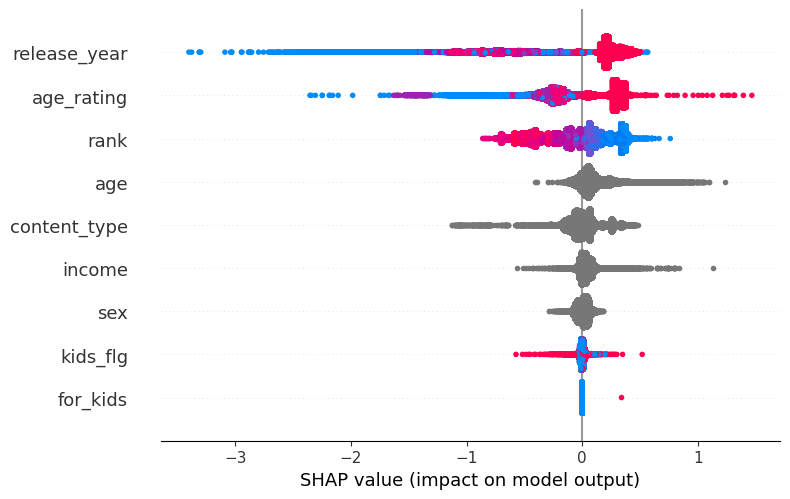

In [117]:
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [118]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

In [120]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.68


# TODO
- Estimate the performance of the model on the test set using Precision@K, MRR, MAP@K: LightFM seperately, LightFM + Ranker

In [121]:
# your code should be here